# Mean Punks

In [43]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('default')
from matplotlib.colors import rgb2hex
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import cpunks.cpunks10k as cpunks10k
import cpunks.utils as cputils

Each pixel in the 24x24 grid of pixels in a cryptopunk has a probability of occuring in the full set of cryptounks. For example, the pixel in the upper riht most
postition , [0,0] is 100% likely to be [0., 0., 0., 1.0]. We can show this using the maximum likelihood assumption which states
that the likelihood of a pixel being value, x, is equal to the mean of all values. For [0,0], the mean is the transparency channels. 

For other pixels, the mean is not as obvious. In this chapter, we'll explore the 'mean punks', that is the set of punks that can be generated by taking hthe max. likelihood of many subsets of punks. 

First, load the data.

In [3]:
cp = cpunks10k.cpunks10k()
(X_train, Y_train), (X_test, Y_test), (labels) = cp.load_data()
X = np.concatenate((X_train, X_test), axis=0)
df = cp.punks_df

Imagine there were only two CryptoPunks ever created: 7252 and 5905.

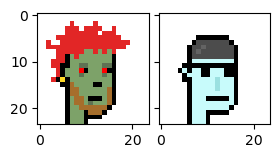

In [44]:
cputils.show(X, idx=[7252, 5905])

First approach, mean likelihood.

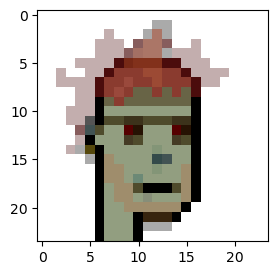

In [6]:
z = np.concatenate(([X[7252]], [X[5905]], X[[1]]), axis=0)
y = np.mean(z, axis=0)
fig = plt.figure(figsize=(3., 3.))
plt.imshow(y)

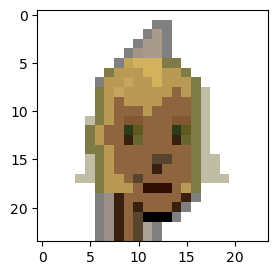

In [302]:
y = np.mean(X[0:2], axis=0)
fig = plt.figure(figsize=(3., 3.))
plt.imshow(y)

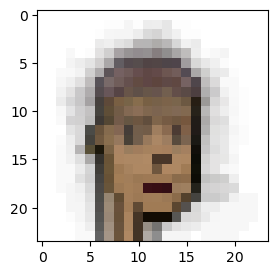

In [304]:
y = np.mean(X, axis=0)
fig = plt.figure(figsize=(3., 3.))
plt.imshow(y)

### Playing Around

In [7]:
class ColorMap:
    transparency = np.array([0., 0., 0., 0.], dtype = np.float32)
    white = np.array([1., 1., 1., 1.], dtype = np.float32)
    black = np.array([0., 0., 0., 1.], dtype = np.float32)
    s1 = np.array([0.68235296, 0.54509807, 0.38039216, 1.], dtype = np.float32)
    s2 = np.array([0.44313726, 0.24705882, 0.11372549, 1.], dtype = np.float32)
    s3 = np.array([0.85882354, 0.69411767, 0.5019608 , 1.], dtype = np.float32)
    s4 = np.array([0.91764706, 0.8509804 , 0.8509804 , 1.], dtype = np.float32)
    
    def color_to_black_white(self, color):
        if np.all(color == self.transparency):
            return color
        if np.all(color == self.s1) or np.all(color == self.s2) or np.all(color == self.s3) or np.all(color == self.s4):
            return self.white
        return self.black
    
    def bg_to_color(self, color, bg_color):
        if np.all(color == self.transparency):
            return bg_color
        return color
    
    def img_bg_to_color(self, img, color):
        return np.array([[self.bg_to_color(c, color) for c in row] for row in img])
        
    
    def img_to_black_white(self, img):
        return np.array([[self.color_to_black_white(c) for c in row] for row in img])

In [8]:
cm = ColorMap()

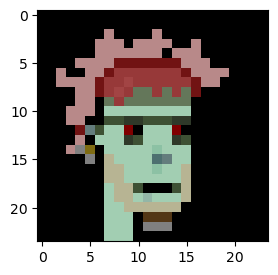

In [9]:
z = np.concatenate(([X[7252]], [X[5905]]), axis=0)
y = np.mean(z, axis=0)

fig = plt.figure(figsize=(3., 3.))
plt.imshow(cm.img_bg_to_color(y, cm.black))

### Structure and Stricture

While these images may be interesting and can be fun to play with, by definition, they not cryptopunks. When we build new images, we used
our aesthetci judgement to select based on visual interest, color balance, and other things we as humans liek about images. but we probalby did not consider,
are these really cryptopunks. ther yare not , because they use coors that are derived from punkls but are not inthe set of 223 colors. if we want to build a naive bayes model for generating crypto punks, we;ll need to ome up with a new deinition of mean.

in this case, we want to select the color most likely to occur within for that pixel value. for [0,0] this will still be the tranpsarency channel
becuase it is the only pixel tat can appear. 
for pixel 12,12 we have a different story.
12,12 has the following distribution over the 10,000 cryptopunks

total = 10,000
c = {color : count}*
distribution = max([count/total for color in c])

we have the distribution, now we select from the distribution to find value.

this is much different model and creates very different images - but, these images ARE cryptopunks

# try a naive approach first

In [34]:
a = np.array([
      [
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
    
      ],
      [
        [1., 1., 1., 1.],
        [1., 1., 1., 1.],
      ]
])
b = np.array([
      [
        [0,0,0,1.],
        [0,0,0,1.],
    
      ],
      [
        [0,0,0,1.],
        [0,0,0,1.],
      ],
])
a_b = np.concatenate(([a],[b]), axis = 0)

In [50]:

def choose_likely_image(X):
    color_table={}
    (n_imgs, n_rows, n_cols, n_chan) = X.shape
    z = X.reshape(n_imgs, (n_rows * n_cols), n_chan)
    color_counts = [{} for i in range(0,z.shape[1])]
    for row in z:
        for idx, v in enumerate(row):
           v_str = str(v)
           color_table[v_str] = v
           color_counts[idx][v_str] = color_counts[idx].get(v_str, 0) + 1

    probs=[]
    for count_d in color_counts:
        #s = sum(list(count_d.values()))
        s = n_imgs
        probs.append([ (k,(v/s)) for (k,v) in count_d.items()])

    mean_img = np.array(
        [
            color_table[np.random.choice([x for (x,y) in prob], p=[y for (x,y) in prob])] 
            for prob in probs
        ]
    )
    return mean_img.reshape(n_rows, n_cols, n_chan)


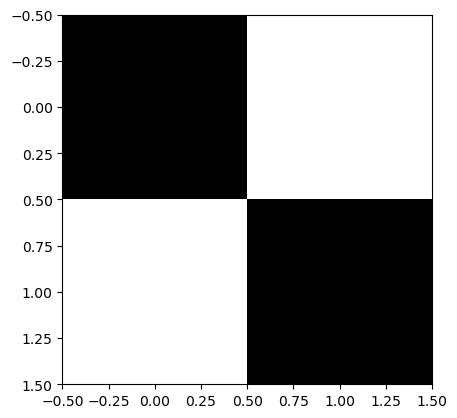

In [51]:
plt.imshow(choose_likely_image(a_b))

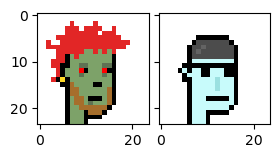

In [12]:
show(X, idx=[7252, 5905])

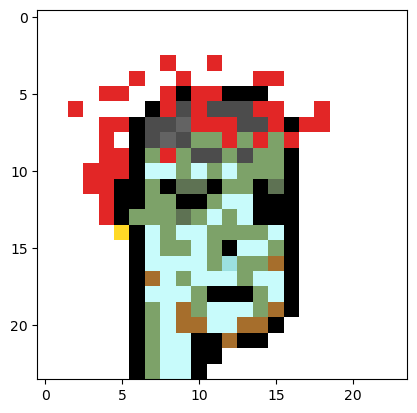

In [52]:
#x = np.concatenate(([a],[b]), axis = 0)
x = np.concatenate(([X[7252]], [X[5905]]), axis=0)
plt.imshow(choose_likely_image(x))

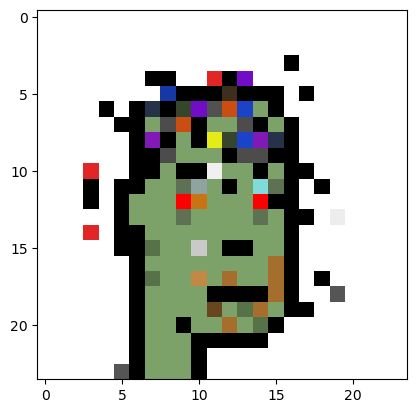

In [55]:
### Mean Zombies
zombies = df.loc[df['zombie'] == 1]
x = zombies['img'].to_numpy()
x = np.array([row[0] for row in x])
plt.imshow(choose_likely_image(x))


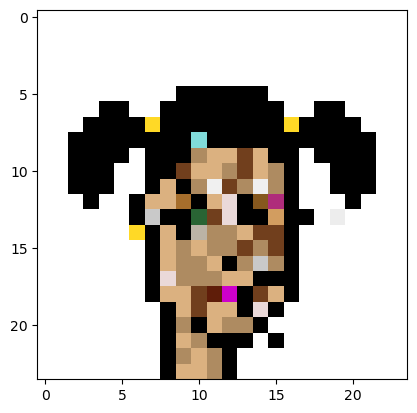

In [28]:
### Mean Pigtails
df_s = df.loc[df['pigtails'] == 1]
x = df_s['img'].to_numpy()
x = np.array([row[0] for row in x])
plt.imshow(choose_likely_image(x))